In [36]:
import numpy as np
import scipy
from skimage import data, io, color, transform, exposure
from skimage.transform import resize as rs
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from PIL import Image


%matplotlib inline
# notebook
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [2]:
# loading the data and doing the 2D Fourier transform on it
train_amt = 10

# real valied matrices which represent the images
trainS = [io.imread("S" + str(i+1) + ".GIF") for i in range(train_amt)]
trainT = [io.imread("T" + str(i+1) + ".GIF") for i in range(train_amt)]
trainV = [io.imread("V" + str(i+1) + ".GIF") for i in range(train_amt)]

# compelx valued matrices which represent the FTs of the images
trainSFourier = [np.fft.fft2(trainS[i]) for i in range(train_amt)]
trainTFourier = [np.fft.fft2(trainT[i]) for i in range(train_amt)]
trainVFourier = [np.fft.fft2(trainV[i]) for i in range(train_amt)]

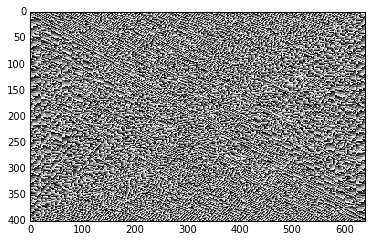

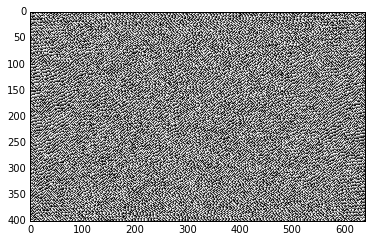

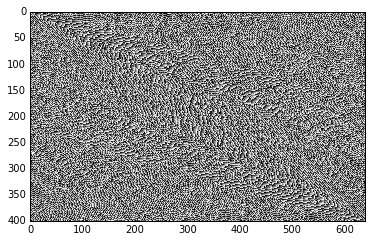

In [5]:
# Viewing the Fourier phase space of S,T,V respectively

ax_im = io.imshow(np.angle(trainSFourier[0]))
io.show()
ax_im = io.imshow(np.angle(trainTFourier[0]))
io.show()
ax_im = io.imshow(np.angle(trainVFourier[0]))
io.show()

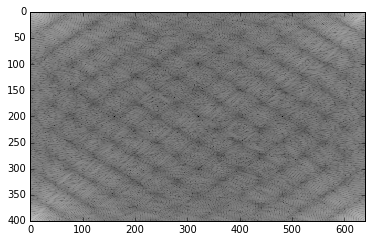

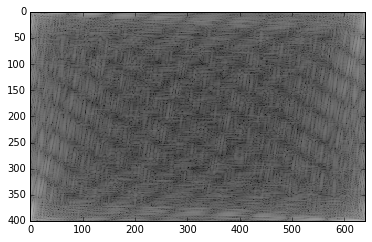

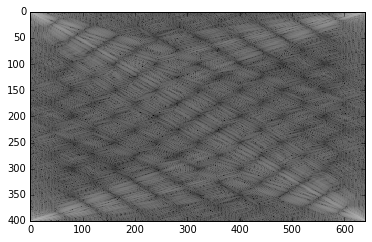

In [8]:
# Viewing the Fourier amplitude space of S,T,V respectively

ax_im = io.imshow(np.log(np.abs(trainSFourier[0]) + 1))
io.show()
ax_im = io.imshow(np.log(np.abs(trainTFourier[0]) + 1))
io.show()
ax_im = io.imshow(np.log(np.abs(trainVFourier[0]) + 1))
io.show()

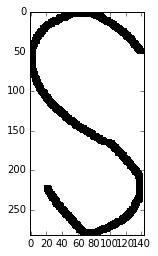

In [6]:
def cropper(image):
    ymax, ymin, xmax, xmin = 1000000, 1000000, 1000000, 1000000

    
    for i in range(0, trainS[0].shape[0]):
        for j in range(1, trainS[0].shape[1]):
            if image[i, j] < image[i, j-1]:
                ymax = i  

    for i in range(trainS[0].shape[0], 0, -1):
        for j in range(1, trainS[0].shape[1]):
            if image[i-1, j] < image[i-1, j-1]:
                ymin = i

    for j in range(0, trainS[0].shape[1]):
        for i in range(1, trainS[0].shape[0]):
            if image[i, j] < image[i, j-1]:
                xmax = j
            
    for j in range(trainS[0].shape[1], 0, -1):
        for i in range(1, trainS[0].shape[0]):
            if image[i-1, j-1] < image[i-1, j-2]:
                xmin = j
            
    cropped_image = image[ymin:ymax, xmin:xmax+10]
    return cropped_image

ax_im = io.imshow(cropper(trainS[3]))

In [8]:
# Crop the images

trainScropped = list(map(cropper, trainS))
trainTcropped = list(map(cropper, trainT))
trainVcropped = list(map(cropper, trainV))

In [50]:
def getAverageRatio(imageList):
    ratios = []
    for i in range(0, len(imageList)):
        ratios.append(imageList[i].shape)
    floatAvg = tuple(np.mean(ratios, axis = 0))
    intAvg = (int(floatAvg[0]), int(floatAvg[1]))
    return intAvg
    
# Resize all images of each character to the average size
def imageResizer(imageList):
    avgRatio = getAverageRatio(imageList)
    for i in range(0, len(imageList)):
        imageList[i] = rs(imageList[i], avgRatio)
    return imageList

# testing to see whether all image sizes are same
x = imageResizer(trainScropped)
for i in range(0, len(x)):
    print(x[i].shape)

(265, 152)
(265, 152)
(265, 152)
(265, 152)
(265, 152)
(265, 152)
(265, 152)
(265, 152)
(265, 152)
(265, 152)


In [51]:
# cropping and resizing everything to their average ratios

trainScroppedAndResized = imageResizer(trainScropped)
trainTcroppedAndResized = imageResizer(trainTcropped)
trainVcroppedAndResized = imageResizer(trainVcropped)

In [52]:
trainSFourierNew = [np.fft.fft2(trainScroppedAndResized[i]) for i in range(train_amt)]
trainTFourierNew = [np.fft.fft2(trainTcroppedAndResized[i]) for i in range(train_amt)]
trainVFourierNew = [np.fft.fft2(trainVcroppedAndResized[i]) for i in range(train_amt)]

In [53]:
#FEATURE EXTRACTION

def boxpass(fourierDomain):
    # extracts a rectangular region from Fourier space
    xmid = fourierDomain.shape[0] / 2
    ymid = fourierDomain.shape[1] / 2
    s = 0
    for x in range(0, int(xmid*2) - 1):
        for y in range(0, int(ymid*2) - 1):
            s += fourierDomain[x, y]**2
    return s

#def circlepass(fourierDomain):
    # extracts a circular region from Fourier space
#    s = 0
#    for r in range(0, R):
        

feature1 = np.array([boxpass(np.angle(trainTFourierNew[i])) for i in range(train_amt)])
feature2 = np.array([boxpass(np.log(np.abs(trainTFourierNew[i]) + 1)) for i in range(train_amt)])
feature3 = np.array([boxpass(np.angle(trainSFourierNew[i])) for i in range(train_amt)])
feature4 = np.array([boxpass(np.log(np.abs(trainSFourierNew[i]) + 1)) for i in range(train_amt)])
feature5 = np.array([boxpass(np.angle(trainVFourierNew[i])) for i in range(train_amt)])
feature6 = np.array([boxpass(np.log(np.abs(trainVFourierNew[i]) + 1)) for i in range(train_amt)])

[[160143.86346529 222917.7334789 ]
 [150736.7611861  174020.96727222]
 [167958.09580712 142630.46368941]
 [193154.83506558 166097.43653809]
 [187539.99382538 170339.00590798]
 [150736.7611861  174020.96727222]
 [168118.4616149  190986.20998558]
 [177607.68157271 227363.19856721]
 [180688.27961173 230519.00052286]
 [127053.01687392 131551.46759742]
 [130219.72427766 261554.46650847]
 [131793.29306104 234462.23348577]
 [130122.39955864 237707.24819387]
 [131094.45744231 242871.30008078]
 [133198.79127811 263853.39329008]
 [131022.45375858 237722.39334694]
 [128667.2577387  145351.81818123]
 [131985.79458139 255671.21102226]
 [131437.01207448 247695.74320302]
 [131674.07098953 270270.43626065]
 [215415.29569791 323425.90713936]
 [200858.81932393 322916.2967804 ]
 [217880.3920047  336951.03974052]
 [217020.60898541 346781.4078421 ]
 [219466.11271176 311835.97063271]
 [199895.57296428 339653.77501725]
 [199766.64380471 233083.37215218]
 [202732.76567568 314095.40702088]
 [201179.38854353 33

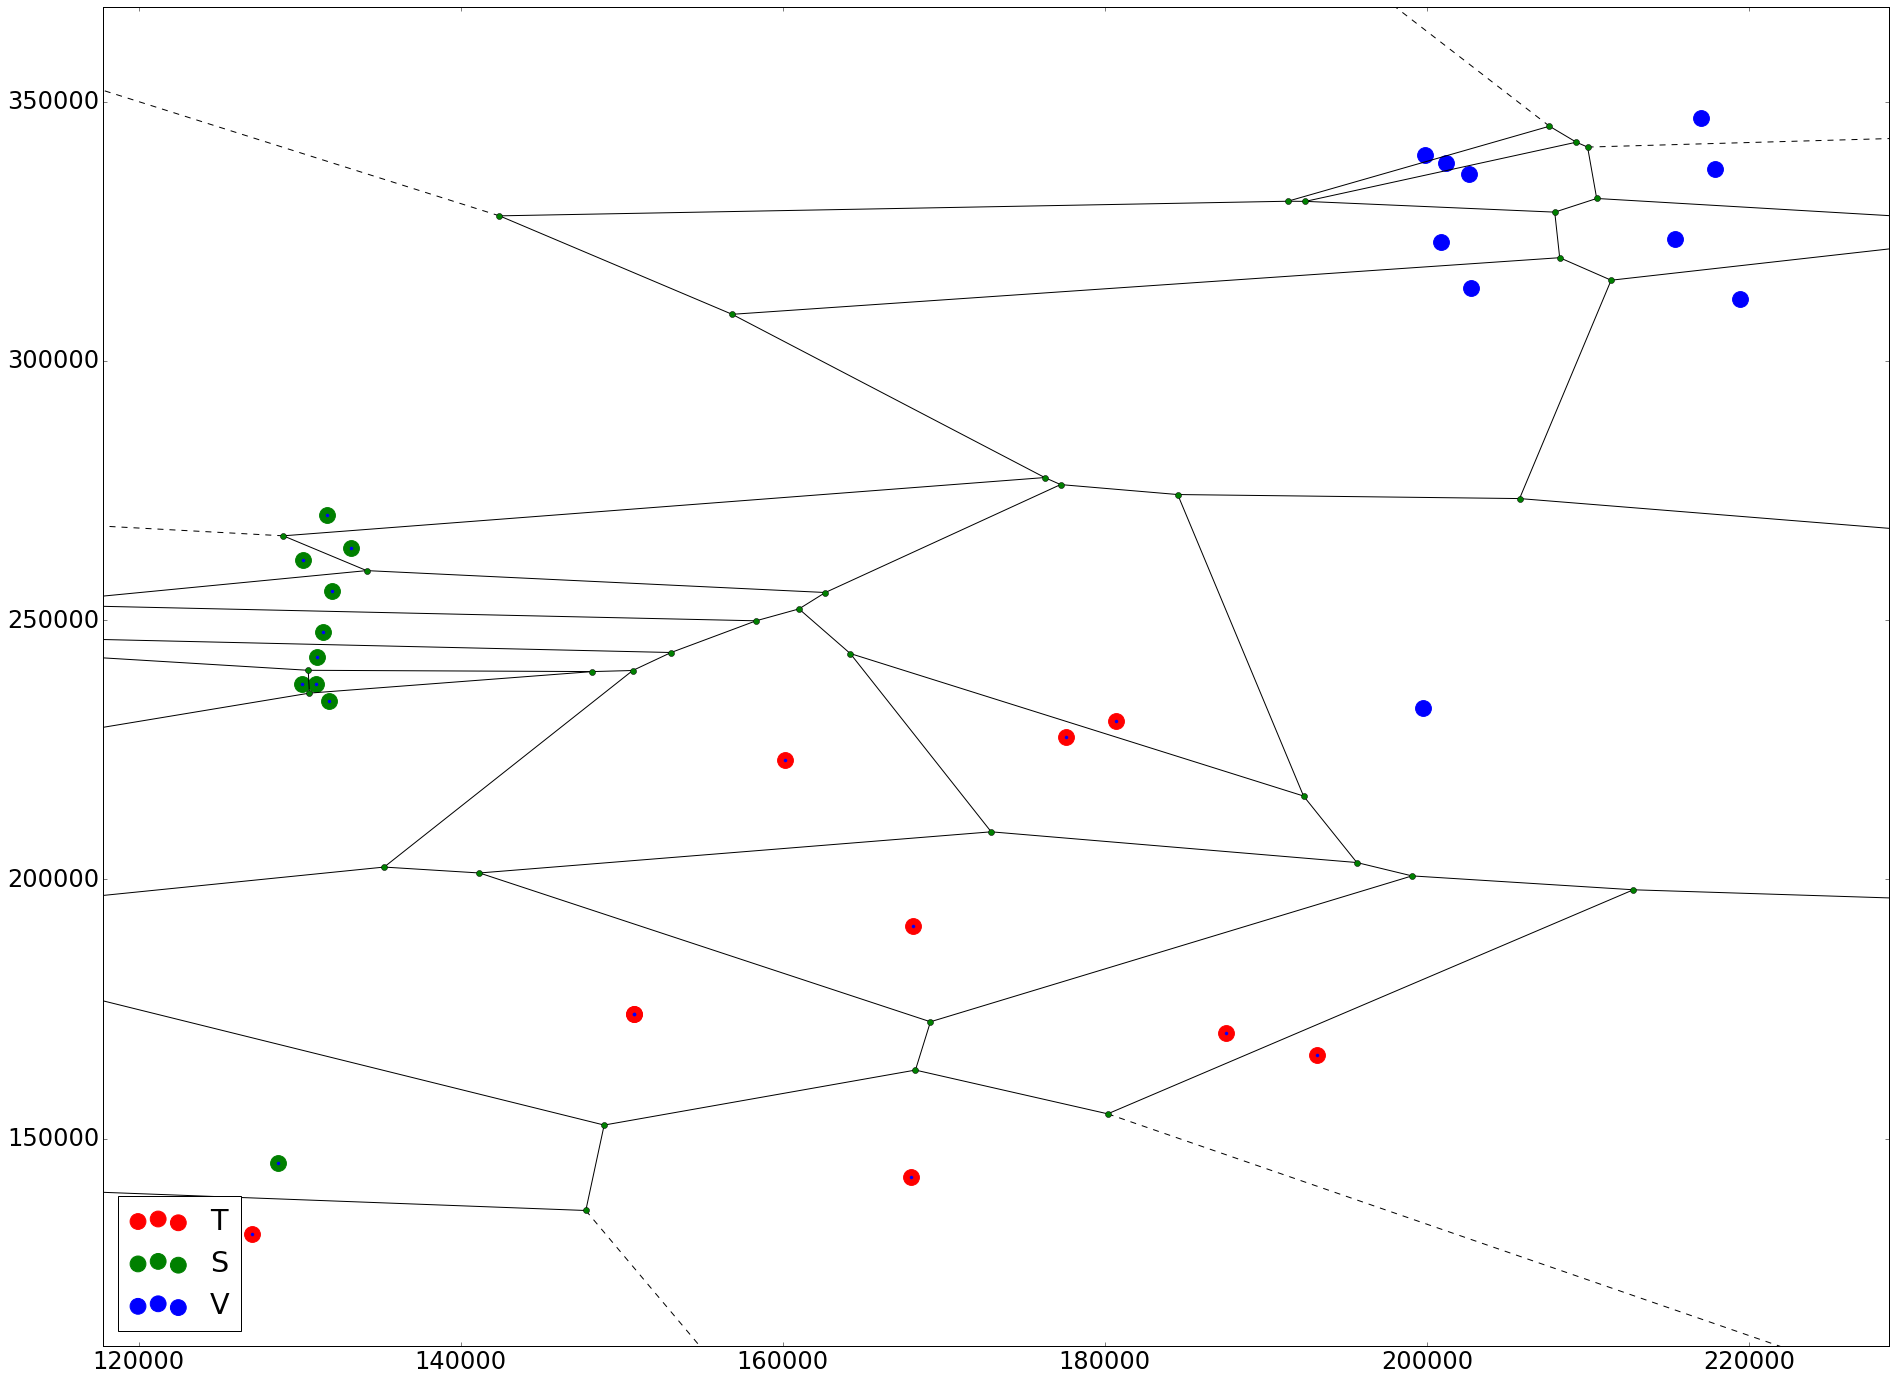

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(feature1, feature2, s=250, color="r", label="T")
ax.scatter(feature3, feature4, s=250, color="g", label="S")
ax.scatter(feature5, feature6, s=250, color="b", label="V")
ax.legend(loc=3)
forvoronoi1 = [[x[0], x[1]] for x in zip(feature1, feature2)]
forvoronoi2 = [[x[0], x[1]] for x in zip(feature3, feature4)]
forvoronoi3 = [[x[0], x[1]] for x in zip(feature5, feature6)]
points = np.array(forvoronoi1 + forvoronoi2 + forvoronoi3)
vor = Voronoi(points)
print(points)
voronoi_plot_2d(vor, ax)
plt.show()